# HW2
Author: Moiz Rasheed

## Part 2: Understanding Data Normalization
**The mystery question: If the pixel-value scaling by the piece of code in
Slide 28 is on a per-image basis and if the same by the code shown on Slide
26 is on a batch basis, how come the two results are exactly the same?**

Looking at part of [the source code](https://pytorch.org/vision/stable/_modules/torchvision/transforms/functional.html#to_tensor) of `to_tensor`, the function used within `ToTensor.__call__()`, 
that handles numpy arrays: 
```python
    if isinstance(pic, np.ndarray):
        # handle numpy array
        if pic.ndim == 2:
            pic = pic[:, :, None]

        img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()  #(**)
        # backward compatibility
        if isinstance(img, torch.ByteTensor):
            return img.to(dtype=default_float_dtype).div(255)          #(*)
        else:
            return img
```
Line * shows that for numpy arrays of type `numpy.uint8` (which
will be converted to tensors of type `ByteTensor` in line \**), the tensor 
is divided by the hardcoded value 255, which was the same max used as the divisor
in slide 26.

## Part 3: Programming Tasks
### 3.1: Setting Up Your Conda Enironment
My `environment.yaml` file is included in the zip. But I prefer making python environments using the built-in python module venv.

### 3.2: Becoming Familiar with `torchvision.transforms`

In [63]:
from PIL import Image

straight_pic = Image.open('stop_straight.jpg')
oblique_pic = Image.open('stop_oblique.jpg')


In [64]:
import torchvision.transforms.functional as TF
import torchvision.transforms as tvt

totensor = tvt.ToTensor()
topil = tvt.ToPILImage()

straight_img = totensor(straight_pic)
# new_img = TF.affine(straight_img, 0, (0,0), 1, 50)
x0 = 533
y0 = 1430
x1 = 2475
y1 = 3245

px0 = 902
py0 = 814
px1 = 2150
py1 = 3245
w,h = straight_pic.size
new_img = TF.perspective(straight_img, [[x0,y0],[x1,y0],[x1,y1],[x0,y1]], [[px0,py0],[px1,py0-200],[px1+200,py1+200],[px0,py1]])
new_img = TF.affine(new_img, -10, (0,0), 1, 0)
new_pic = topil(new_img)
new_pic.save('new.jpg')


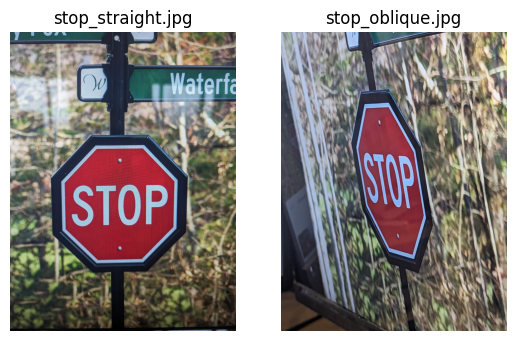

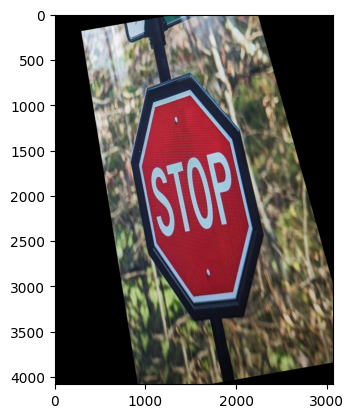

In [67]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

fig = plt.figure()
list_of_files = ['stop_straight.jpg', 'stop_oblique.jpg']
number_of_files = len(list_of_files)
for i in range(number_of_files):
    a=fig.add_subplot(1,number_of_files,i+1)
    image = imread(list_of_files[i])
    plt.imshow(image)
    plt.axis('off')
    a.set_title(list_of_files[i])
    
fig2 = plt.figure()
image = imread('new.jpg')
plt.imshow(image)

In the above images, the two on top are the originals and the one on bottom was generated by transforming `stop_straight.jpg`. I solved this task by making measurements on the `stop_straight.jpg` image and the `stop_oblique.jpg` image to determine the perspective and rotation transformation parameters.

### 3.3: Creating Your Own Dataset Class

In [88]:
import os
import torch

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, root):
        super().__init__()
        self.image_files = os.listdir(root)
        self.image_files = [os.path.join(root,file) for file in self.image_files]
        
        self.transform = tvt.Compose([
            tvt.ToTensor(),
            tvt.Resize(200),
            tvt.ColorJitter(brightness=.5, hue=.3),
            tvt.RandomAffine(20, (.3, .3), (.75,2)),
            tvt.RandomPerspective()
        ])
        
    def __len__(self):
        return len(self.image_files) * 10
    
    def __getitem__(self, index):
        pic = Image.open(self.image_files[index//10])
        img = self.transform(pic)
        return (img, 0)

In [89]:
my_dataset = MyDataset('dataset')
print(len(my_dataset))

index = 10
val = my_dataset[index]
print(val[0].shape, val[1])

index = 50
val = my_dataset[index]
print(val[0].shape, val[1])

100
torch.Size([3, 265, 200]) 0
torch.Size([3, 265, 200]) 0


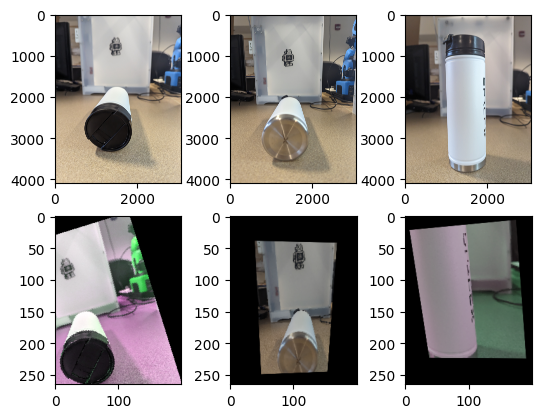

In [90]:
fig = plt.figure()

fig.add_subplot(2, 3, 1)
plt.imshow(Image.open(my_dataset.image_files[0]))
fig.add_subplot(2, 3, 4)
img, _ = my_dataset[0]
plt.imshow(topil(img))

fig.add_subplot(2, 3, 2)
plt.imshow(Image.open(my_dataset.image_files[1]))
fig.add_subplot(2, 3, 5)
img, _ = my_dataset[10]
plt.imshow(topil(img))

fig.add_subplot(2, 3, 3)
plt.imshow(Image.open(my_dataset.image_files[5]))
fig.add_subplot(2, 3, 6)
img, _ = my_dataset[50]
plt.imshow(topil(img))

The above row shows the original images and the bottom row shows the transformed versions. I chose to go with a ColorJitter transform because I thought that it could maybe account for different lighting conditions (such as in second column). I went for the RandomAffine and RandomePerspective transform to account for different positions a camera might take a photo in. I also resized my images because they were taking way to long to load.

### 3.4: Generating Data in Parallel

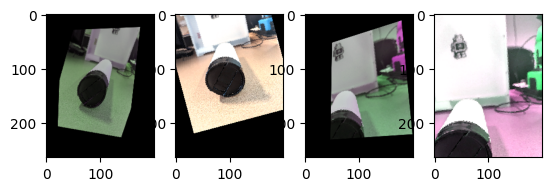

In [91]:
my_dataloader = torch.utils.data.DataLoader(my_dataset, batch_size=4, num_workers=4)
images, labels = next(iter(my_dataloader))

fig = plt.figure()

fig.add_subplot(1, 4, 1)
plt.imshow(topil(images[0]))
fig.add_subplot(1, 4, 2)
plt.imshow(topil(images[1]))
fig.add_subplot(1, 4, 3)
plt.imshow(topil(images[2]))
fig.add_subplot(1, 4, 4)
plt.imshow(topil(images[3]))


In [93]:
import time

start = time.time()
for i in range(1000):
    my_dataset[i//10]
print("dataset time: " + str(time.time() - start))

start = time.time()
for i in range(10):
    for images, labels in my_dataloader:
        pass
print("dataloader time: " + str(time.time() - start))

dataset time: 118.25628113746643
dataloader time: 67.62583518028259


With 4 workers and a batch size of 4, the time difference in loading 1000 images between the dataset and dataloader is shown above. 

After some Googling, I found out each worker loads an entire batch and queues it for use it the future. It would be beneficial then to have more workers if the batch size/loading time of a batch is large in comparison to how fast the batch is fed through the network. But if the network takes a while to compute, it is not necessary to have many batches ready in advance. 